# Computational Drug Design - Final Project

Author: Vojtech Melichar
Year: AY 2022/23

## Import of dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gzip
from itertools import chain

from rdkit import Chem
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import Descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors

from rdkit import RDLogger

RDLogger.DisableLog('rdApp.error')

from sklearn.model_selection import train_test_split

## Standardization of molecules

In [2]:
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol, replaced

In [3]:
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]") # to remove compounds with unwanted atom types
_carbonPatt = Chem.MolFromSmarts("[#6]") # to remove compounds without carbon - inorganic

def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol, neutralized = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                Chem.SanitizeMol(mol) # add catch block?
                return mol
    else:
        return None

## Lipinski's Rule of Five

In [4]:
# do lipinski's rule of five filtering
def lipinski(mol):
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hbd = Lipinski.NumHDonors(mol)
    hba = Lipinski.NumHAcceptors(mol)
    if mw <= 500 and logp <= 5 and hbd <= 5 and hba <= 10:
        return True
    else:
        return False

## PAINs filter

In [5]:
# load PAINS structures in SMARTS format from two files in data
pains = []
with open('../data/pains/p_l15.txt', 'r') as f, open('../data/pains/p_m150.txt', 'r') as p:
    for line in chain(f, p):
        pattern, text = line.strip().split('\t') # split by tab
        pains.append(Chem.MolFromSmarts(pattern)) # remove the xml tags
len(pains)

425

In [6]:
def gen_pains(mol, keys=pains):
    structure_key = [mol.HasSubstructMatch(pain) for pain in pains]
    return sum(structure_key)

## Predicting active/decoys molecules on DUDE dataset

In [76]:
with gzip.open('actives_final.sdf.gz') as sdf:
    supp_actives = Chem.ForwardSDMolSupplier(sdf)
    actives = [[mol, 'actives'] for mol in supp_actives if mol]

with gzip.open('decoys_final.sdf.gz') as sdf:
    supp_decoys = Chem.ForwardSDMolSupplier(sdf)
    decoys = [[mol, 'decoys'] for mol in supp_decoys if mol]

df_ac = pd.DataFrame(actives, columns=['Mol', 'Source'])
df_de = pd.DataFrame(decoys, columns=['Mol', 'Source'])

df_c = pd.concat((df_ac, df_de), ignore_index=True)
df_c

,Mol,Source
0,<rdkit.Chem.rdchem.Mol object at 0x7f77ebfe57b0>,actives
1,<rdkit.Chem.rdchem.Mol object at 0x7f77ebfe5850>,actives
2,<rdkit.Chem.rdchem.Mol object at 0x7f77ebff3210>,actives
3,<rdkit.Chem.rdchem.Mol object at 0x7f77ebfe58f0>,actives
4,<rdkit.Chem.rdchem.Mol object at 0x7f77ebfe5990>,actives
...,...,...
29121,<rdkit.Chem.rdchem.Mol object at 0x7f77c18945d0>,decoys
29122,<rdkit.Chem.rdchem.Mol object at 0x7f77c1894670>,decoys
29123,<rdkit.Chem.rdchem.Mol object at 0x7f77c1894710>,decoys
29124,<rdkit.Chem.rdchem.Mol object at 0x7f77c18947b0>,decoys


In [77]:
df_c['Mol'] = df_c['Mol'].apply(standardize)
print(f'{df_c["Mol"].isna().sum()} molecules could not be standardized')
df_c.dropna(inplace=True)

104 molecules could not be standardized


In [78]:
df_c['lip5'] = df_c['Mol'].apply(lipinski)
print(f'{df_c["lip5"].sum()} molecules pass Lipinski\'s rule of five')
print(f'{df_c.shape[0] - df_c["lip5"].sum()} molecules do not pass Lipinski\'s rule of five')

26405 molecules pass Lipinski's rule of five
2617 molecules do not pass Lipinski's rule of five


In [79]:
df_c['pains'] = df_c['Mol'].apply(gen_pains)
print(f"{df_c[df_c['pains'] > 0].pains.shape[0]} molecules contain PAINS substructures")
print(df_c.pains.value_counts())
df_c = df_c[df_c['pains'] == 0]

418 molecules contain PAINS substructures
0    28604
1      417
2        1
Name: pains, dtype: int64


In [80]:
fp_df_c = pd.DataFrame((list(rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)) for mol in df_c["Mol"]), columns=[*(f"FP_{x}" for x in range(1,1025))])
fp_df_c = fp_df_c.join(df_c["Source"])
print(fp_df_c.shape)

fp_df_c.replace([np.inf, -np.inf], np.nan, inplace=True)
fp_df_c.dropna(inplace=True)
print(fp_df_c.shape)
fp_df_c['Source'] = fp_df_c['Source'].apply(lambda x: True if x == 'actives' else False)
fp_df_c

(28604, 1025)
(28093, 1025)


,FP_1,FP_2,FP_3,FP_4,FP_5,FP_6,FP_7,FP_8,FP_9,FP_10,...,FP_1016,FP_1017,FP_1018,FP_1019,FP_1020,FP_1021,FP_1022,FP_1023,FP_1024,Source
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
5,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,True
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,True
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,True
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28599,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,False
28600,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,False
28601,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,False
28602,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,False


In [81]:
# train test split
X = fp_df_c.drop("Source", axis=1)
y = fp_df_c["Source"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((16855, 1024), (16855,), (5619, 1024), (5619,), (5619, 1024), (5619,))

In [82]:
# do lgbm classification
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbose': -1
}

gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

# find best threshold
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
threshold = thresholds[np.argmax(precision[:-1] == recall[:-1])]
print(f"Best threshold: {threshold}")

Best threshold: 0.0716597520969334


Accuracy: 0.995906744972415
Precision: 0.9197080291970803
Recall: 0.9130434782608695
F1: 0.9163636363636363
ROC AUC: 0.955518272609727


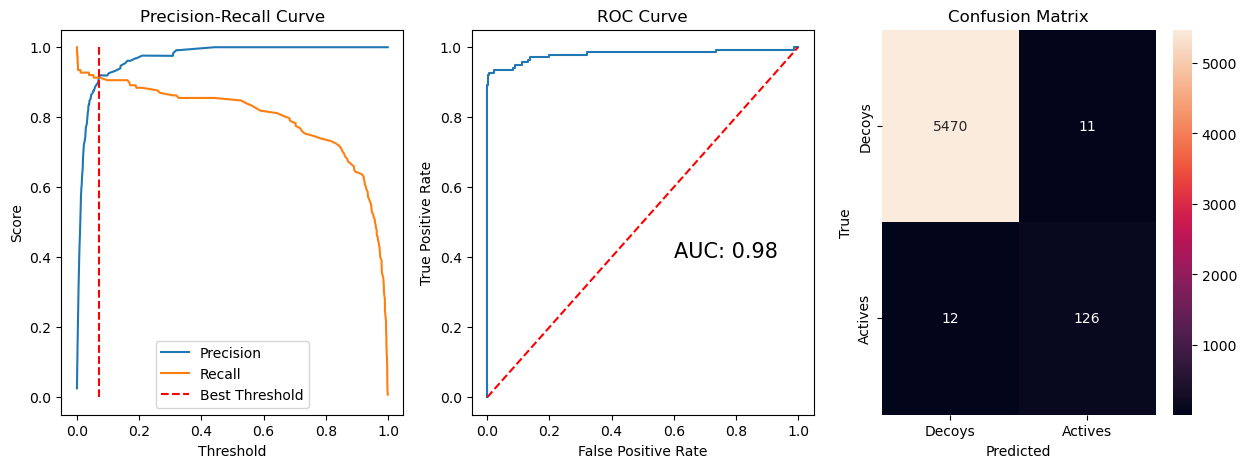

In [83]:
# plot subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

ax1.plot(thresholds, precision[:-1], label="Precision")
ax1.plot(thresholds, recall[:-1], label="Recall")
ax1.vlines(threshold, 0, 1, linestyles='--', color='red', label="Best Threshold")
ax1.set_xlabel("Threshold")
ax1.set_ylabel("Score")
ax1.set_title("Precision-Recall Curve")
ax1.legend()

# plot roc curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

ax2.plot(fpr, tpr)
ax2.plot([0,1], [0,1], linestyle='--', color='red')
ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax2.set_title("ROC Curve")
# auc score in plot
ax2.text(0.6, 0.4, f"AUC: {roc_auc_score(y_test, y_pred).round(2)}", fontsize=15)

# print metrics for best threshold
y_pred = y_pred > threshold

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1: {f1_score(y_test, y_pred)}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")

# plot confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='g')
ax3.set_xlabel("Predicted")
ax3.set_ylabel("True")
ax3.set_title("Confusion Matrix")
ax3.xaxis.set_ticklabels(['Decoys', 'Actives'])
ax3.yaxis.set_ticklabels(['Decoys', 'Actives'])
plt.show()

## Predicting active/decoy molecules on ChEMBL dataset using previous model

In [54]:
df = pd.read_csv('cdk2_x.csv', sep=';')
df = df[['Smiles', 'pChEMBL Value']]
df.columns = ['Smiles', 'pChEMBL']
df.dropna(inplace=True)
df['Mol'] = df.Smiles.apply(Chem.MolFromSmiles)
df

,Smiles,pChEMBL,Mol
0,CC(=O)c1c(C)c2cnc(Nc3ccc(N4CCNCC4)cn3)nc2n(C2C...,8.00,<rdkit.Chem.rdchem.Mol object at 0x7f77b370bda0>
1,CS(=N)(=O)Cc1cccc(Nc2ncc(F)c(-c3ccc(F)cc3OCc3c...,6.11,<rdkit.Chem.rdchem.Mol object at 0x7f77b370b210>
2,COc1cc(CS(C)(=O)=NC#N)cc(Nc2ncc(F)c(-c3ccc(F)c...,6.89,<rdkit.Chem.rdchem.Mol object at 0x7f77b370bcb0>
3,C1=C/Cn2ccc3ccc(cc32)-c2ccnc(n2)Nc2ccc(OCCN3CC...,6.64,<rdkit.Chem.rdchem.Mol object at 0x7f77b370b170>
4,O=[N+]([O-])c1ccc(Nc2nccc(-c3cnn4ncccc34)n2)cc1,8.52,<rdkit.Chem.rdchem.Mol object at 0x7f77b370b5d0>
...,...,...,...
2757,CC1CN(c2ccc(Nc3ncc4cc5n(c4n3)C3(CCCC3)CNC5=O)n...,4.78,<rdkit.Chem.rdchem.Mol object at 0x7f77b3ae8530>
2758,O=C1NCC2(CCCC2)n2c1cc1cnc(Nc3ccc(N4CCNCC4)cn3)...,4.96,<rdkit.Chem.rdchem.Mol object at 0x7f77b3ae8580>
2759,CCN1[C@H](C)CN(c2ccc(Nc3ncc4cc5n(c4n3)C3(CCCCC...,5.33,<rdkit.Chem.rdchem.Mol object at 0x7f77b3ae85d0>
2761,O=C1NCC2(CCCCC2)n2c1cc1cnc(Nc3ccc(C(=O)N4CCN(C...,6.97,<rdkit.Chem.rdchem.Mol object at 0x7f77b3ae8620>


In [55]:
df['Mol'] = df['Mol'].apply(standardize)
print(f'{df["Mol"].isna().sum()} molecules could not be standardized')
df.dropna(inplace=True)

5 molecules could not be standardized


In [57]:
df['lip5'] = df['Mol'].apply(lipinski)
print(f'{df["lip5"].sum()} molecules pass Lipinski\'s rule of five')
print(f'{df.shape[0] - df["lip5"].sum()} molecules do not pass Lipinski\'s rule of five')

1668 molecules pass Lipinski's rule of five
232 molecules do not pass Lipinski's rule of five


In [62]:
df['pains'] = df['Mol'].apply(gen_pains)
print(f"{df[df['pains'] > 0].pains.shape[0]} molecules contain PAINS substructures")
print(df.pains.value_counts())
df = df[df['pains'] == 0]

133 molecules contain PAINS substructures
0    1767
1     133
Name: pains, dtype: int64


In [63]:
fp_df = pd.DataFrame((list(rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)) for mol in df["Mol"]), columns=[*(f"FP_{x}" for x in range(1,1025))])
fp_df = fp_df.join(df["pChEMBL"])
print(fp_df.shape)

fp_df.replace([np.inf, -np.inf], np.nan, inplace=True)
fp_df.dropna(inplace=True)
print(fp_df.shape)
fp_df

(1767, 1025)
(1115, 1025)


,FP_1,FP_2,FP_3,FP_4,FP_5,FP_6,FP_7,FP_8,FP_9,FP_10,...,FP_1016,FP_1017,FP_1018,FP_1019,FP_1020,FP_1021,FP_1022,FP_1023,FP_1024,pChEMBL
0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,8.00
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,6.11
2,0,0,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,6.89
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.64
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1761,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,6.34
1762,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,7.17
1763,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,8.02
1765,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,8.15


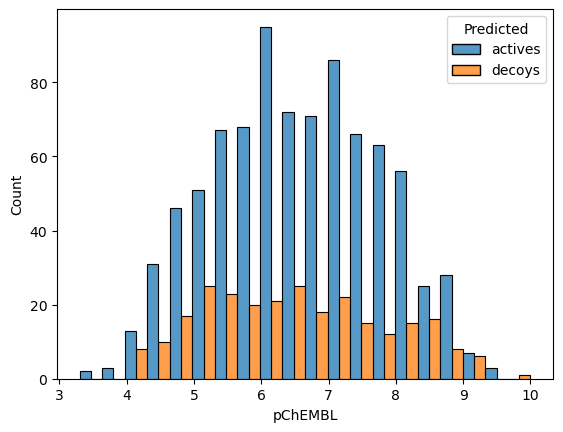

In [87]:
X = fp_df.drop("pChEMBL", axis=1)
y = fp_df["pChEMBL"]

y_pred_chembl = gbm.predict(X, num_iteration=gbm.best_iteration)
print

y_pred_chembl = ['actives' if i > threshold else 'decoys' for i in y_pred_chembl]

fp_df['Predicted'] = y_pred_chembl

distributions = pd.DataFrame({'pChEMBL': y, 'Predicted': y_pred_chembl})

distributions['Predicted'].value_counts()

# hist by predicted
sns.histplot(data=distributions, x='pChEMBL', hue='Predicted', bins=20, multiple='dodge')
plt.show()

In [85]:
# do t test for distibutions
from scipy.stats import ttest_ind

actives = distributions[distributions['Predicted'] == 'actives']['pChEMBL']
decoys = distributions[distributions['Predicted'] == 'decoys']['pChEMBL']

ttest_ind(actives, decoys)

Ttest_indResult(statistic=0.8613731619578981, pvalue=0.3892180819417572)

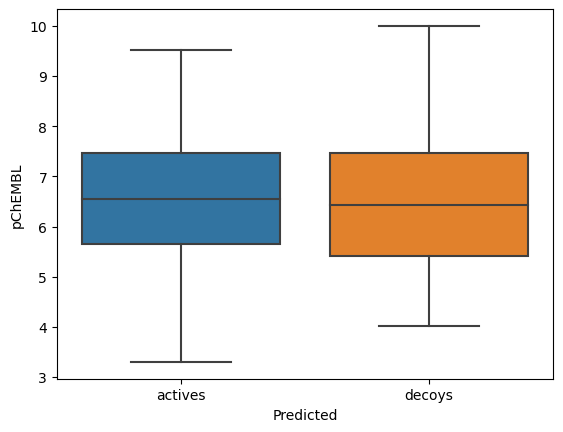

In [75]:
# boxplot by predicted
sns.boxplot(data=distributions, x='Predicted', y='pChEMBL')
plt.show()

## Visualizing molecules in chemical space

In [89]:
# distance matrix
from scipy.spatial.distance import pdist, squareform

dist = pdist(fp_df.drop(["pChEMBL", 'Predicted'], axis=1), metric='jaccard')
dist = squareform(dist)
dist

array([[0.        , 0.84466019, 0.86238532, ..., 0.51898734, 0.64516129,
        0.62365591],
       [0.84466019, 0.        , 0.47435897, ..., 0.83333333, 0.85849057,
        0.82857143],
       [0.86238532, 0.47435897, 0.        , ..., 0.86407767, 0.875     ,
        0.85714286],
       ...,
       [0.51898734, 0.83333333, 0.86407767, ..., 0.        , 0.39189189,
        0.31944444],
       [0.64516129, 0.85849057, 0.875     , ..., 0.39189189, 0.        ,
        0.45238095],
       [0.62365591, 0.82857143, 0.85714286, ..., 0.31944444, 0.45238095,
        0.        ]])

/home/vmelichar/anaconda3/envs/PNL/lib/python3.7/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/vmelichar/anaconda3/envs/PNL/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  app.launch_new_instance()


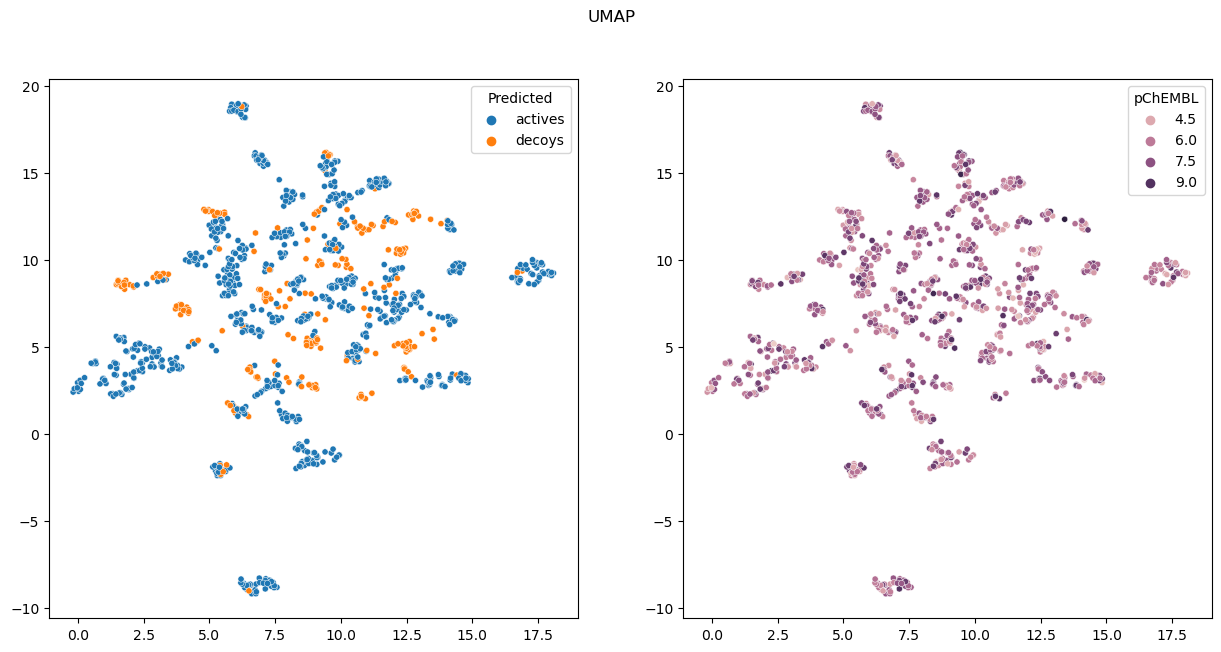

In [122]:
# do umap
import umap

reducer = umap.UMAP(n_neighbors=20, min_dist=0.5, metric='precomputed')
embedding = reducer.fit_transform(dist)

# plot umap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
p1 = sns.scatterplot(
    x=embedding[:,0],
    y=embedding[:,1],
    legend='brief',
    hue=fp_df['Predicted'],
    ax=ax1,
    alpha=1,
    s=20,
    palette=sns.color_palette("tab10", 10)
)
p2 = sns.scatterplot(
    x=embedding[:,0],
    y=embedding[:,1],
    legend='brief',
    hue=fp_df['pChEMBL'],
    ax=ax2,
    alpha=1,
    s=20,
)
fig.suptitle('UMAP')
plt.show()

/home/vmelichar/anaconda3/envs/PNL/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/vmelichar/anaconda3/envs/PNL/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/vmelichar/anaconda3/envs/PNL/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,
/home/vmelichar/anaconda3/envs/PNL/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: The palett

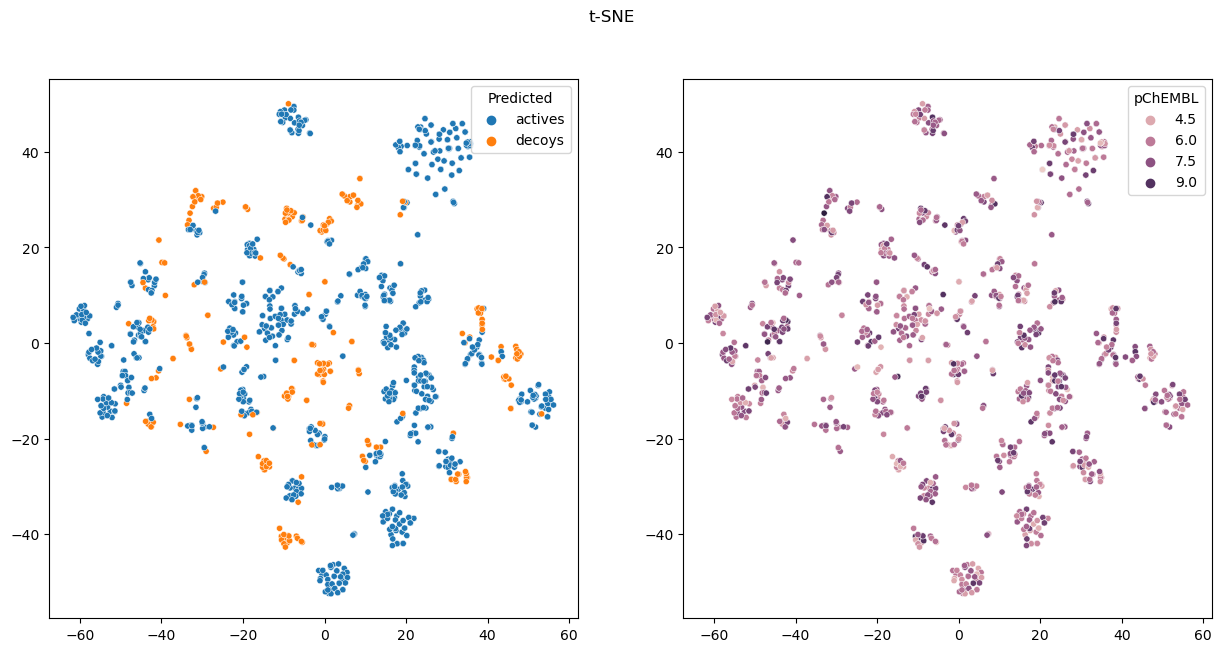

In [123]:
# do tsne
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, metric='precomputed')
embedding = tsne.fit_transform(dist)

# plot tsne
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
p1 = sns.scatterplot(
    x=embedding[:,0],
    y=embedding[:,1],
    legend='brief',
    hue=fp_df['Predicted'],
    ax=ax1,
    alpha=1,
    s=20,
    palette=sns.color_palette("tab10", 10)
)
p2 = sns.scatterplot(
    x=embedding[:,0],
    y=embedding[:,1],
    legend='brief',
    hue=fp_df['pChEMBL'],
    ax=ax2,
    alpha=1,
    s=20,
)
fig.suptitle('t-SNE')
plt.show()

## Scaffold analysis